# Task 1



In [2]:
import os
import json
import urllib.request
import torch
from torch.utils.data import DataLoader
from torchvision.models import resnet34
from torchvision import transforms, datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "/content/TestDataSet/TestDataSet"

class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}

folder_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
folder_to_idx = {}
for folder in folder_names:
    if folder in synset_to_idx:
        folder_to_idx[folder] = synset_to_idx[folder]
    else:
        print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset.class_to_idx = folder_to_idx
dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, pred_top1 = outputs.topk(1, dim=1)
        _, pred_top5 = outputs.topk(5, dim=1)

        top1_correct += (pred_top1.squeeze() == labels).sum().item()
        top5_correct += sum([labels[i].item() in pred_top5[i].tolist() for i in range(len(labels))])
        total += labels.size(0)

top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 138MB/s]


Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# Task 2

Using device: cuda
Evaluating original model on clean dataset...


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 20.23it/s]


Clean Top-1 Accuracy: 76.00%
Clean Top-5 Accuracy: 94.20%
Generating adversarial examples with FGSM (ε = 0.02)...


Generating adversarial examples: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s]


Maximum L∞ distance: 0.020000100135803223
Evaluating original model on adversarial dataset...


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 33.63it/s]


Adversarial Top-1 Accuracy: 6.00%
Adversarial Top-5 Accuracy: 35.40%
Top-1 Accuracy Drop: 70.00%
Top-5 Accuracy Drop: 58.80%
Saving adversarial dataset...
Visualizing successful adversarial examples...


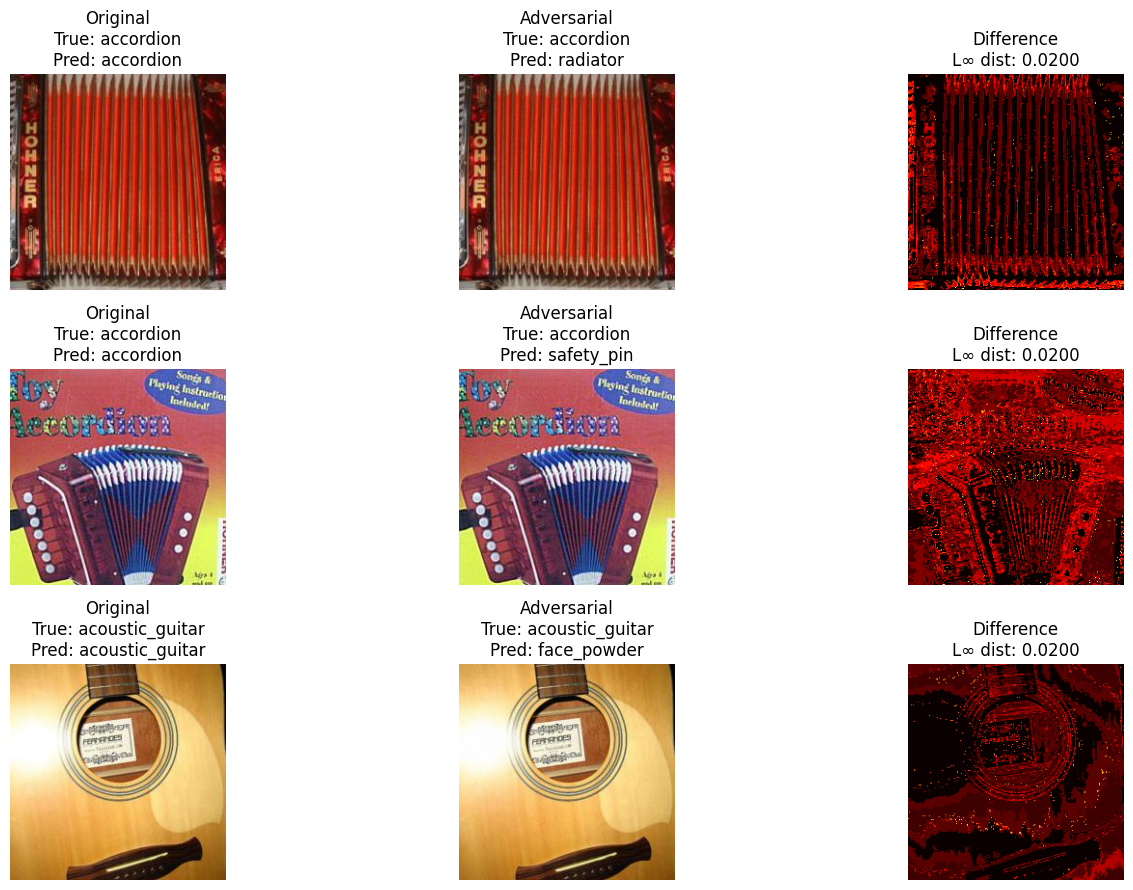

Done! Adversarial Test Set 1 has been created and model performance has been evaluated.


In [3]:
import os
import json
import urllib.request
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet34
from torchvision import transforms, datasets
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "/content/TestDataSet/TestDataSet"

class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}
idx_to_label = {int(k): v[1] for k, v in class_index.items()}

folder_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
folder_to_idx = {}
for folder in folder_names:
    if folder in synset_to_idx:
        folder_to_idx[folder] = synset_to_idx[folder]
    else:
        print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset.class_to_idx = folder_to_idx
dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

def denormalize(tensor):
    """Convert normalized image tensor to numpy array for visualization"""
    tensor = tensor.clone().detach().cpu()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1).numpy().transpose(1, 2, 0)

def evaluate_model(model, dataloader, top_k=(1, 5)):
    """Evaluate model performance on given dataloader"""
    model.eval()
    top_k_correct = {k: 0 for k in top_k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = outputs.topk(max(top_k), dim=1)

            for k in top_k:
                top_k_preds = predictions[:, :k]

                for i in range(labels.size(0)):
                    if labels[i].item() in top_k_preds[i]:
                        top_k_correct[k] += 1

            total += labels.size(0)

    accuracy = {k: (top_k_correct[k] / total) * 100 for k in top_k}
    return accuracy

print("Evaluating original model on clean dataset...")
clean_accuracy = evaluate_model(model, dataloader)
print(f"Clean Top-1 Accuracy: {clean_accuracy[1]:.2f}%")
print(f"Clean Top-5 Accuracy: {clean_accuracy[5]:.2f}%")

def fgsm_attack(model, images, labels, epsilon=0.02):
    """
    Generate adversarial examples using Fast Gradient Sign Method (FGSM)

    Args:
        model: neural network model
        images: input images
        labels: true labels
        epsilon: attack budget

    Returns:
        perturbed_images: adversarial examples
    """
    perturbed_images = images.clone().detach().requires_grad_(True)

    outputs = model(perturbed_images)

    loss = torch.nn.functional.cross_entropy(outputs, labels)

    model.zero_grad()

    loss.backward()

    with torch.no_grad():
        perturbation = epsilon * torch.sign(perturbed_images.grad.data)

        perturbed_images = perturbed_images.detach() + perturbation

        for i in range(3):  # For each channel
            min_val = images[:, i].min() - epsilon
            max_val = images[:, i].max() + epsilon
            perturbed_images[:, i] = torch.clamp(perturbed_images[:, i], min=min_val, max=max_val)

    return perturbed_images

class AdversarialDataset(Dataset):
    def __init__(self, adv_images, labels):
        self.adv_images = adv_images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adv_images[idx], self.labels[idx]

def generate_adversarial_dataset(model, dataloader, epsilon=0.02):
    """Generate adversarial examples for the entire dataset"""
    model.eval()
    adv_images = []
    original_images = []
    original_labels = []
    predicted_clean_labels = []
    predicted_adv_labels = []
    l_inf_distances = []

    for images, labels in tqdm(dataloader, desc="Generating adversarial examples"):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, clean_preds = outputs.max(1)

        adv_imgs = fgsm_attack(model, images, labels, epsilon)

        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, adv_preds = adv_outputs.max(1)

        l_inf_dist = (adv_imgs - images).abs().max(dim=1)[0].max(dim=1)[0].max(dim=1)[0]

        adv_images.append(adv_imgs.cpu())
        original_images.append(images.cpu())
        original_labels.append(labels.cpu())
        predicted_clean_labels.append(clean_preds.cpu())
        predicted_adv_labels.append(adv_preds.cpu())
        l_inf_distances.append(l_inf_dist.cpu())

    adv_images = torch.cat(adv_images)
    original_images = torch.cat(original_images)
    original_labels = torch.cat(original_labels)
    predicted_clean_labels = torch.cat(predicted_clean_labels)
    predicted_adv_labels = torch.cat(predicted_adv_labels)
    l_inf_distances = torch.cat(l_inf_distances)

    return {
        'adv_images': adv_images,
        'original_images': original_images,
        'original_labels': original_labels,
        'predicted_clean_labels': predicted_clean_labels,
        'predicted_adv_labels': predicted_adv_labels,
        'l_inf_distances': l_inf_distances
    }

print("Generating adversarial examples with FGSM (ε = 0.02)...")
adv_data = generate_adversarial_dataset(model, dataloader, epsilon=0.02)

max_l_inf = adv_data['l_inf_distances'].max().item()
print(f"Maximum L∞ distance: {max_l_inf}")
tolerance = 1e-6
assert max_l_inf <= 0.02 + tolerance, f"L∞ distance exceeds budget significantly: {max_l_inf} > 0.02"

adv_dataset = AdversarialDataset(adv_data['adv_images'], adv_data['original_labels'])
adv_dataloader = DataLoader(adv_dataset, batch_size=16, shuffle=False)

print("Evaluating original model on adversarial dataset...")
adv_accuracy = evaluate_model(model, adv_dataloader)
print(f"Adversarial Top-1 Accuracy: {adv_accuracy[1]:.2f}%")
print(f"Adversarial Top-5 Accuracy: {adv_accuracy[5]:.2f}%")
print(f"Top-1 Accuracy Drop: {clean_accuracy[1] - adv_accuracy[1]:.2f}%")
print(f"Top-5 Accuracy Drop: {clean_accuracy[5] - adv_accuracy[5]:.2f}%")

print("Saving adversarial dataset...")
adv_dataset_path = "/content/AdversarialTestSet1"
os.makedirs(adv_dataset_path, exist_ok=True)

class_folders = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

for folder in class_folders:
    os.makedirs(os.path.join(adv_dataset_path, folder), exist_ok=True)

def save_tensor_as_image(tensor, path):
    img_np = denormalize(tensor)
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    img_pil.save(path)

counter = 0
for idx, (img_path, label) in enumerate(dataset.samples):
    class_folder = os.path.basename(os.path.dirname(img_path))
    img_name = os.path.basename(img_path)

    save_path = os.path.join(adv_dataset_path, class_folder, img_name)
    save_tensor_as_image(adv_data['adv_images'][counter], save_path)
    counter += 1

def visualize_adversarial_examples(orig_imgs, adv_imgs, orig_labels,
                                  clean_preds, adv_preds, class_dict, num_examples=3):
    """Visualize successful adversarial examples"""
    successful_idx = []

    for i in range(len(orig_labels)):
        if clean_preds[i].item() == orig_labels[i].item() and adv_preds[i].item() != orig_labels[i].item():
            successful_idx.append(i)

            if len(successful_idx) >= num_examples:
                break

    if len(successful_idx) == 0:
        print("No successful attacks found!")
        return

    plt.figure(figsize=(15, 3*len(successful_idx)))

    for i, idx in enumerate(successful_idx):
        plt.subplot(len(successful_idx), 3, i*3 + 1)
        plt.imshow(denormalize(orig_imgs[idx]))
        true_label = class_dict.get(orig_labels[idx].item(), f"Class {orig_labels[idx].item()}")
        pred_label = class_dict.get(clean_preds[idx].item(), f"Class {clean_preds[idx].item()}")
        plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")
        plt.axis('off')

        plt.subplot(len(successful_idx), 3, i*3 + 2)
        plt.imshow(denormalize(adv_imgs[idx]))
        adv_pred_label = class_dict.get(adv_preds[idx].item(), f"Class {adv_preds[idx].item()}")
        plt.title(f"Adversarial\nTrue: {true_label}\nPred: {adv_pred_label}")
        plt.axis('off')

        plt.subplot(len(successful_idx), 3, i*3 + 3)
        diff = (adv_imgs[idx] - orig_imgs[idx]).abs().mean(dim=0)
        diff = diff / diff.max() if diff.max() > 0 else diff
        plt.imshow(diff.cpu().numpy(), cmap='hot')
        plt.title(f"Difference\nL∞ dist: {(adv_imgs[idx] - orig_imgs[idx]).abs().max().item():.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("/content/adversarial_examples.png")
    plt.show()

print("Visualizing successful adversarial examples...")
visualize_adversarial_examples(
    adv_data['original_images'],
    adv_data['adv_images'],
    adv_data['original_labels'],
    adv_data['predicted_clean_labels'],
    adv_data['predicted_adv_labels'],
    idx_to_label
)

print("Done! Adversarial Test Set 1 has been created and model performance has been evaluated.")

# Task 3

In [4]:
import os
import json
import urllib.request
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet34
from torchvision import transforms, datasets
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "/content/TestDataSet/TestDataSet"

class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}
idx_to_label = {int(k): v[1] for k, v in class_index.items()}

folder_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
folder_to_idx = {}
for folder in folder_names:
    if folder in synset_to_idx:
        folder_to_idx[folder] = synset_to_idx[folder]
    else:
        print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset.class_to_idx = folder_to_idx
dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

def denormalize(tensor):
    tensor = tensor.clone().detach().cpu()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1).numpy().transpose(1, 2, 0)

def evaluate_model(model, dataloader, top_k=(1, 5)):
    model.eval()
    top_k_correct = {k: 0 for k in top_k}
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = outputs.topk(max(top_k), dim=1)
            for k in top_k:
                top_k_preds = predictions[:, :k]
                for i in range(labels.size(0)):
                    if labels[i].item() in top_k_preds[i]:
                        top_k_correct[k] += 1
            total += labels.size(0)
    accuracy = {k: (top_k_correct[k] / total) * 100 for k in top_k}
    return accuracy

print("Evaluating original model on clean dataset...")
clean_accuracy = evaluate_model(model, dataloader)
print(f"Clean Top-1 Accuracy: {clean_accuracy[1]:.2f}%")
print(f"Clean Top-5 Accuracy: {clean_accuracy[5]:.2f}%")

class AdversarialDataset(Dataset):
    def __init__(self, adv_images, labels):
        self.adv_images = adv_images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adv_images[idx], self.labels[idx]

def save_tensor_as_image(tensor, path):
    img_np = denormalize(tensor)
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    img_pil.save(path)

def get_epsilon_per_channel(epsilon, std_norms):
    return [epsilon / s for s in std_norms]

def improved_attack(model, images, labels, epsilon=0.02, alpha=0.005, num_steps=10):
    epsilon_per_channel = get_epsilon_per_channel(epsilon, std_norms)
    alpha_per_channel = get_epsilon_per_channel(alpha, std_norms)
    perturbed_images = images.clone().detach()
    original_images = images.clone().detach()
    prev_grad = torch.zeros_like(perturbed_images)
    with torch.no_grad():
        outputs = model(images)
        original_probs = torch.softmax(outputs, dim=1)
        sorted_probs, sorted_indices = torch.sort(original_probs, dim=1, descending=True)
        target_indices = sorted_indices[:, torch.randint(900, 950, (images.size(0),))]
    for _ in range(num_steps):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        target_log_probs = torch.nn.functional.log_softmax(outputs, dim=1)
        gathered_logits = target_log_probs[torch.arange(images.size(0)), target_indices]
        loss = -gathered_logits.sum()
        model.zero_grad()
        loss.backward()
        momentum = 0.9
        current_grad = perturbed_images.grad.data
        grad_with_momentum = momentum * prev_grad + current_grad / current_grad.abs().mean()
        prev_grad = grad_with_momentum.clone()
        with torch.no_grad():
            for c in range(3):
                perturbed_images[:, c, :, :] = perturbed_images[:, c, :, :].detach() - alpha_per_channel[c] * torch.sign(grad_with_momentum[:, c, :, :])
            for c in range(3):
                delta = perturbed_images[:, c, :, :] - original_images[:, c, :, :]
                delta = torch.clamp(delta, min=-epsilon_per_channel[c], max=epsilon_per_channel[c])
                perturbed_images[:, c, :, :] = original_images[:, c, :, :] + delta
    return perturbed_images

def calculate_linf_distance(adv_images, orig_images):
    denorm_adv = adv_images.clone().detach()
    denorm_orig = orig_images.clone().detach()
    for c in range(3):
        denorm_adv[:, c, :, :] = denorm_adv[:, c, :, :] * std_norms[c] + mean_norms[c]
        denorm_orig[:, c, :, :] = denorm_orig[:, c, :, :] * std_norms[c] + mean_norms[c]
    l_inf_dist = (denorm_adv - denorm_orig).abs().max(dim=1)[0].max(dim=1)[0].max(dim=1)[0]
    return l_inf_dist

def generate_improved_adversarial_dataset(model, dataloader, epsilon=0.02):
    model.eval()
    adv_images = []
    original_images = []
    original_labels = []
    predicted_clean_labels = []
    predicted_adv_labels = []
    l_inf_distances = []
    for images, labels in tqdm(dataloader, desc="Generating improved adversarial examples"):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            _, clean_preds = outputs.max(1)
        adv_imgs = improved_attack(model, images, labels, epsilon=epsilon)
        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, adv_preds = adv_outputs.max(1)
        l_inf_dist = calculate_linf_distance(adv_imgs, images)
        adv_images.append(adv_imgs.cpu())
        original_images.append(images.cpu())
        original_labels.append(labels.cpu())
        predicted_clean_labels.append(clean_preds.cpu())
        predicted_adv_labels.append(adv_preds.cpu())
        l_inf_distances.append(l_inf_dist.cpu())
    adv_images = torch.cat(adv_images)
    original_images = torch.cat(original_images)
    original_labels = torch.cat(original_labels)
    predicted_clean_labels = torch.cat(predicted_clean_labels)
    predicted_adv_labels = torch.cat(predicted_adv_labels)
    l_inf_distances = torch.cat(l_inf_distances)
    return {
        'adv_images': adv_images,
        'original_images': original_images,
        'original_labels': original_labels,
        'predicted_clean_labels': predicted_clean_labels,
        'predicted_adv_labels': predicted_adv_labels,
        'l_inf_distances': l_inf_distances
    }

print("Generating improved adversarial examples (targeted PGD attack with momentum)...")
adv_data = generate_improved_adversarial_dataset(model, dataloader, epsilon=0.02)

max_l_inf = adv_data['l_inf_distances'].max().item()
print(f"Maximum L∞ distance: {max_l_inf}")
tolerance = 1e-6
assert max_l_inf <= 0.02 + tolerance, f"L∞ distance exceeds budget significantly: {max_l_inf} > 0.02"

adv_dataset = AdversarialDataset(adv_data['adv_images'], adv_data['original_labels'])
adv_dataloader = DataLoader(adv_dataset, batch_size=16, shuffle=False)

print("Evaluating original model on improved adversarial dataset...")
adv_accuracy = evaluate_model(model, adv_dataloader)
print(f"Improved Adversarial Top-1 Accuracy: {adv_accuracy[1]:.2f}%")
print(f"Improved Adversarial Top-5 Accuracy: {adv_accuracy[5]:.2f}%")
print(f"Top-1 Accuracy Drop: {clean_accuracy[1] - adv_accuracy[1]:.2f}%")
print(f"Top-5 Accuracy Drop: {clean_accuracy[5] - adv_accuracy[5]:.2f}%")
print(f"Relative Top-1 Accuracy Drop: {(100 * (clean_accuracy[1] - adv_accuracy[1]) / clean_accuracy[1]):.2f}%")
print(f"Relative Top-5 Accuracy Drop: {(100 * (clean_accuracy[5] - adv_accuracy[5]) / clean_accuracy[5]):.2f}%")


Using device: cuda
Evaluating original model on clean dataset...


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 20.19it/s]


Clean Top-1 Accuracy: 76.00%
Clean Top-5 Accuracy: 94.20%
Generating improved adversarial examples (targeted PGD attack with momentum)...


Generating improved adversarial examples: 100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Maximum L∞ distance: 0.020000100135803223
Evaluating original model on improved adversarial dataset...


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 34.63it/s]


Improved Adversarial Top-1 Accuracy: 4.40%
Improved Adversarial Top-5 Accuracy: 10.80%
Top-1 Accuracy Drop: 71.60%
Top-5 Accuracy Drop: 83.40%
Relative Top-1 Accuracy Drop: 94.21%
Relative Top-5 Accuracy Drop: 88.54%
Generating visualizations of successful attacks...
Visualizing 5 successful adversarial attacks...
  Attack 1: Changed prediction from cardigan to ballplayer
  Attack 2: Changed prediction from bassinet to loggerhead
  Attack 3: Changed prediction from barber_chair to jigsaw_puzzle
  Attack 4: Changed prediction from ambulance to jeep
  Attack 5: Changed prediction from bell_cote to restaurant
Creating batch visualization of 10 successful adversarial attacks...
Batch visualization saved to batch_attack_visualization.png
Class attack success visualization saved to class_attack_success.png
Misclassification heatmap saved to misclassification_heatmap.png
Saving improved adversarial dataset...


# Task 4

Using device: cuda
Evaluating original model on clean dataset...


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 18.24it/s]


Clean Top-1 Accuracy: 76.00%
Clean Top-5 Accuracy: 94.20%
Generating patch adversarial examples (32x32 patch, ε = 0.5)...


Generating patch adversarial examples: 100%|██████████| 32/32 [00:54<00:00,  1.71s/it]


Evaluating model on patch adversarial dataset...


Evaluating: 100%|██████████| 32/32 [00:00<00:00, 33.77it/s]


Patch Adversarial Top-1 Accuracy: 31.40%
Patch Adversarial Top-5 Accuracy: 52.80%
Top-1 Accuracy Drop: 44.60%
Top-5 Accuracy Drop: 41.40%
Relative Top-1 Accuracy Drop: 58.68%
Relative Top-5 Accuracy Drop: 43.95%
Saving patch adversarial dataset...
Visualizing successful patch adversarial examples...


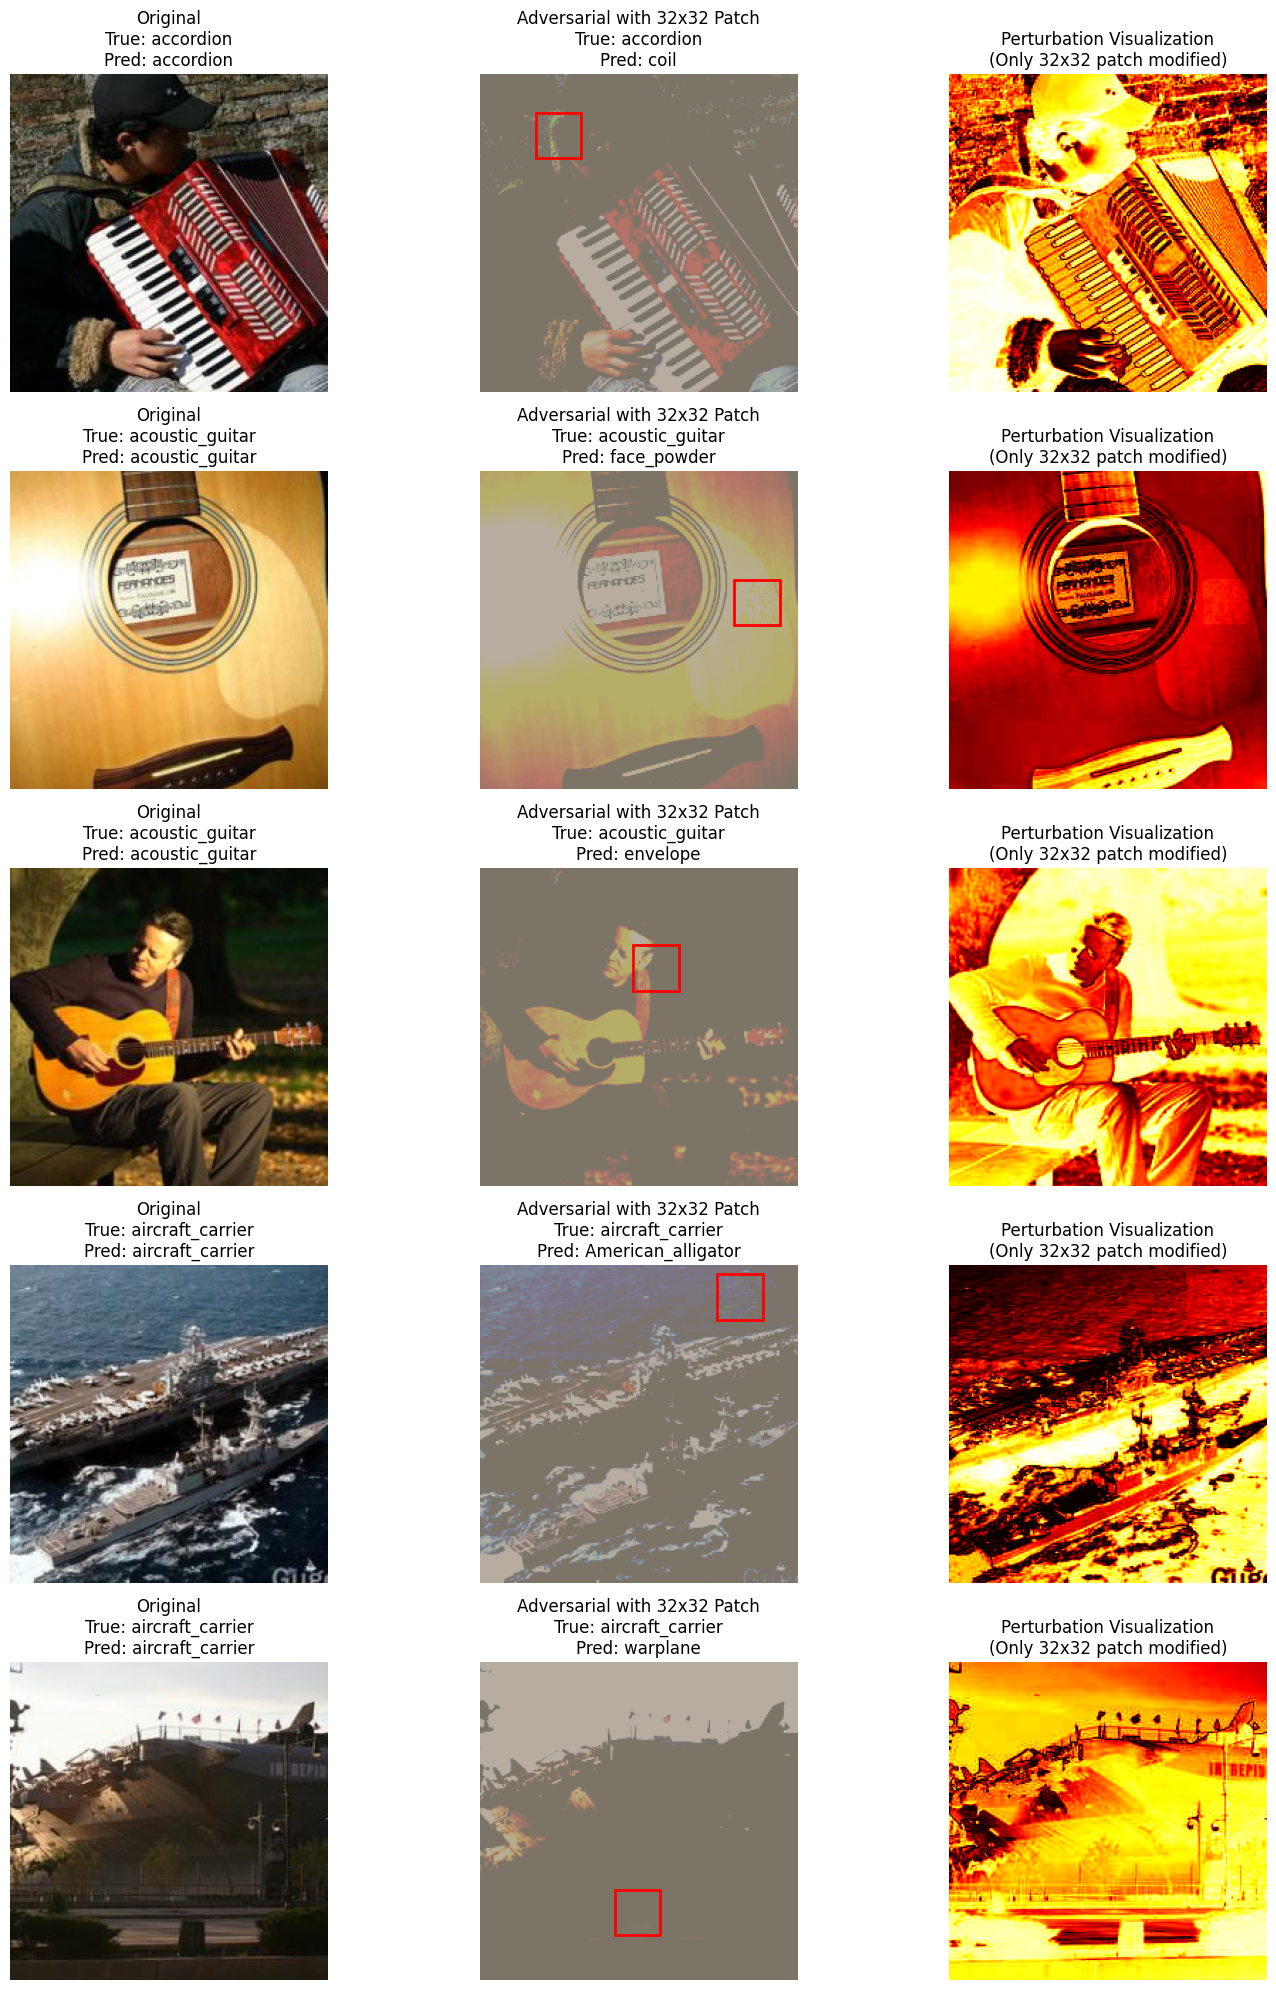

In [5]:
import os
import json
import urllib.request
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet34
from torchvision import transforms, datasets
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = "/content/TestDataSet/TestDataSet"

class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}
idx_to_label = {int(k): v[1] for k, v in class_index.items()}

folder_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
folder_to_idx = {}
for folder in folder_names:
    if folder in synset_to_idx:
        folder_to_idx[folder] = synset_to_idx[folder]
    else:
        print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")

dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset.class_to_idx = folder_to_idx
dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]

dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

def denormalize(tensor):
    tensor = tensor.clone().detach().cpu()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1).numpy().transpose(1, 2, 0)

def evaluate_model(model, dataloader, top_k=(1, 5)):
    model.eval()
    top_k_correct = {k: 0 for k in top_k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = outputs.topk(max(top_k), dim=1)

            for k in top_k:
                top_k_preds = predictions[:, :k]

                for i in range(labels.size(0)):
                    if labels[i].item() in top_k_preds[i]:
                        top_k_correct[k] += 1

            total += labels.size(0)

    accuracy = {k: (top_k_correct[k] / total) * 100 for k in top_k}
    return accuracy

print("Evaluating original model on clean dataset...")
clean_accuracy = evaluate_model(model, dataloader)
print(f"Clean Top-1 Accuracy: {clean_accuracy[1]:.2f}%")
print(f"Clean Top-5 Accuracy: {clean_accuracy[5]:.2f}%")

class AdversarialDataset(Dataset):
    def __init__(self, adv_images, labels):
        self.adv_images = adv_images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.adv_images[idx], self.labels[idx]

def save_tensor_as_image(tensor, path):
    img_np = denormalize(tensor)
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    img_pil.save(path)

def create_patch_mask(img_shape, patch_size=32, position=None):
    _, height, width = img_shape
    mask = torch.zeros(img_shape, device=device)

    if position is None:
        max_x = width - patch_size
        max_y = height - patch_size
        x = torch.randint(0, max(1, max_x), (1,)).item()
        y = torch.randint(0, max(1, max_y), (1,)).item()
    else:
        x, y = position

    mask[:, y:y+patch_size, x:x+patch_size] = 1.0
    return mask, (x, y)

def patch_attack(model, images, labels, epsilon=0.5, alpha=0.1, num_steps=20, patch_size=32):
    batch_size = images.size(0)
    perturbed_images = images.clone().detach()
    patch_masks = []
    patch_positions = []

    for i in range(batch_size):
        mask, position = create_patch_mask(images[i].shape, patch_size=patch_size)
        patch_masks.append(mask)
        patch_positions.append(position)

    patch_masks = torch.stack(patch_masks)
    momentum_accum = torch.zeros_like(images)

    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, sorted_indices = torch.sort(probs, dim=1)
        target_indices = sorted_indices[:, torch.randint(20, 40, (batch_size,))]

    for step in range(num_steps):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        target_log_probs = torch.nn.functional.log_softmax(outputs, dim=1)
        gathered_logits = target_log_probs[torch.arange(batch_size), target_indices]
        loss = -gathered_logits.sum()
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            grad = perturbed_images.grad.data
            momentum = 0.9
            momentum_accum = momentum * momentum_accum + grad / torch.mean(torch.abs(grad), dim=(1, 2, 3), keepdim=True)
            delta = alpha * torch.sign(momentum_accum)
            delta = delta * patch_masks
            perturbed_images = perturbed_images.detach() - delta
            delta = perturbed_images - images
            delta = torch.clamp(delta, min=-epsilon, max=epsilon)
            delta = delta * patch_masks
            perturbed_images = images + delta
            perturbed_images = torch.clamp(perturbed_images, min=0, max=1)

    return perturbed_images, patch_positions

def generate_patch_adversarial_dataset(model, dataloader, epsilon=0.5, patch_size=32):
    model.eval()
    adv_images = []
    original_images = []
    original_labels = []
    predicted_clean_labels = []
    predicted_adv_labels = []
    patch_positions_list = []

    for images, labels in tqdm(dataloader, desc="Generating patch adversarial examples"):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, clean_preds = outputs.max(1)

        adv_imgs, patch_pos = patch_attack(
            model, images, labels,
            epsilon=epsilon,
            alpha=epsilon/5,
            num_steps=20,
            patch_size=patch_size
        )

        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, adv_preds = adv_outputs.max(1)

        adv_images.append(adv_imgs.cpu())
        original_images.append(images.cpu())
        original_labels.append(labels.cpu())
        predicted_clean_labels.append(clean_preds.cpu())
        predicted_adv_labels.append(adv_preds.cpu())
        patch_positions_list.extend(patch_pos)

    adv_images = torch.cat(adv_images)
    original_images = torch.cat(original_images)
    original_labels = torch.cat(original_labels)
    predicted_clean_labels = torch.cat(predicted_clean_labels)
    predicted_adv_labels = torch.cat(predicted_adv_labels)

    return {
        'adv_images': adv_images,
        'original_images': original_images,
        'original_labels': original_labels,
        'predicted_clean_labels': predicted_clean_labels,
        'predicted_adv_labels': predicted_adv_labels,
        'patch_positions': patch_positions_list
    }

print("Generating patch adversarial examples (32x32 patch, ε = 0.5)...")
patch_adv_data = generate_patch_adversarial_dataset(model, dataloader, epsilon=0.5, patch_size=32)

patch_adv_dataset = AdversarialDataset(patch_adv_data['adv_images'], patch_adv_data['original_labels'])
patch_adv_dataloader = DataLoader(patch_adv_dataset, batch_size=16, shuffle=False)

print("Evaluating model on patch adversarial dataset...")
patch_adv_accuracy = evaluate_model(model, patch_adv_dataloader)
print(f"Patch Adversarial Top-1 Accuracy: {patch_adv_accuracy[1]:.2f}%")
print(f"Patch Adversarial Top-5 Accuracy: {patch_adv_accuracy[5]:.2f}%")
print(f"Top-1 Accuracy Drop: {clean_accuracy[1] - patch_adv_accuracy[1]:.2f}%")
print(f"Top-5 Accuracy Drop: {clean_accuracy[5] - patch_adv_accuracy[5]:.2f}%")
print(f"Relative Top-1 Accuracy Drop: {(100 * (clean_accuracy[1] - patch_adv_accuracy[1]) / clean_accuracy[1]):.2f}%")
print(f"Relative Top-5 Accuracy Drop: {(100 * (clean_accuracy[5] - patch_adv_accuracy[5]) / clean_accuracy[5]):.2f}%")

print("Saving patch adversarial dataset...")
patch_adv_dataset_path = "/content/AdversarialTestSet3"
os.makedirs(patch_adv_dataset_path, exist_ok=True)

class_folders = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

for folder in class_folders:
    os.makedirs(os.path.join(patch_adv_dataset_path, folder), exist_ok=True)

counter = 0
for idx, (img_path, label) in enumerate(dataset.samples):
    class_folder = os.path.basename(os.path.dirname(img_path))
    img_name = os.path.basename(img_path)
    save_path = os.path.join(patch_adv_dataset_path, class_folder, img_name)
    save_tensor_as_image(patch_adv_data['adv_images'][counter], save_path)
    counter += 1

def visualize_patch_adversarial_examples(orig_imgs, adv_imgs, orig_labels,
                                         clean_preds, adv_preds, patch_positions,
                                         class_dict, num_examples=5):
    successful_idx = []

    for i in range(len(orig_labels)):
        if clean_preds[i].item() == orig_labels[i].item() and adv_preds[i].item() != orig_labels[i].item():
            successful_idx.append(i)
            if len(successful_idx) >= num_examples:
                break

    if len(successful_idx) == 0:
        print("No successful attacks found!")
        return

    plt.figure(figsize=(15, 4*len(successful_idx)))

    for i, idx in enumerate(successful_idx):
        plt.subplot(len(successful_idx), 3, i*3 + 1)
        plt.imshow(denormalize(orig_imgs[idx]))
        true_label = class_dict.get(orig_labels[idx].item(), f"Class {orig_labels[idx].item()}")
        pred_label = class_dict.get(clean_preds[idx].item(), f"Class {clean_preds[idx].item()}")
        plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")
        plt.axis('off')

        plt.subplot(len(successful_idx), 3, i*3 + 2)
        adv_img = denormalize(adv_imgs[idx])
        plt.imshow(adv_img)
        x, y = patch_positions[idx]
        patch_size = 32
        rect = plt.Rectangle((x, y), patch_size, patch_size, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        adv_pred_label = class_dict.get(adv_preds[idx].item(), f"Class {adv_preds[idx].item()}")
        plt.title(f"Adversarial with 32x32 Patch\nTrue: {true_label}\nPred: {adv_pred_label}")
        plt.axis('off')

        plt.subplot(len(successful_idx), 3, i*3 + 3)
        diff = (adv_imgs[idx] - orig_imgs[idx]).abs().mean(dim=0)
        diff = diff / diff.max() if diff.max() > 0 else diff
        plt.imshow(diff.cpu().numpy(), cmap='hot')
        plt.title(f"Perturbation Visualization\n(Only 32x32 patch modified)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("/content/patch_adversarial_examples.png")
    plt.show()

print("Visualizing successful patch adversarial examples...")
visualize_patch_adversarial_examples(
    patch_adv_data['original_images'],
    patch_adv_data['adv_images'],
    patch_adv_data['original_labels'],
    patch_adv_data['predicted_clean_labels'],
    patch_adv_data['predicted_adv_labels'],
    patch_adv_data['patch_positions'],
    idx_to_label,
    num_examples=5
)


# Task 5: Transferring attacks

Using device: cuda
Loaded Original dataset with 500 images
Loaded Adversarial 1 dataset with 500 images
Loaded Adversarial 2 dataset with 500 images
Loaded Adversarial 3 dataset with 500 images


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 222MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 225MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 207MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 99.4MB/s]



Evaluating DenseNet-121...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  5.80it/s]



Evaluating ResNet-50...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.24it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.41it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.51it/s]



Evaluating MobileNetV3-Large...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 13.13it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 14.37it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 14.09it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 13.18it/s]



Evaluating EfficientNet-B0...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.48it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 12.07it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 12.10it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 12.12it/s]



Evaluating VGG16...
  on Original dataset...


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]


  on Adversarial 1 dataset...


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]


  on Adversarial 2 dataset...


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.49it/s]


  on Adversarial 3 dataset...


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.67it/s]



===== EVALUATION RESULTS =====

DenseNet-121:
-------------
Dataset         Top-1 Acc (%)   Top-5 Acc (%)  
--------------- --------------- ---------------
Original        74.80           93.60          
Adversarial 1   70.80           92.20          
Adversarial 2   60.60           86.80          
Adversarial 3   38.80           61.00          

ResNet-50:
----------
Dataset         Top-1 Acc (%)   Top-5 Acc (%)  
--------------- --------------- ---------------
Original        80.20           94.60          
Adversarial 1   75.40           93.60          
Adversarial 2   67.00           88.20          
Adversarial 3   31.80           52.40          

MobileNetV3-Large:
------------------
Dataset         Top-1 Acc (%)   Top-5 Acc (%)  
--------------- --------------- ---------------
Original        83.80           97.00          
Adversarial 1   79.40           96.40          
Adversarial 2   71.20           91.00          
Adversarial 3   41.80           68.20          

EfficientNet

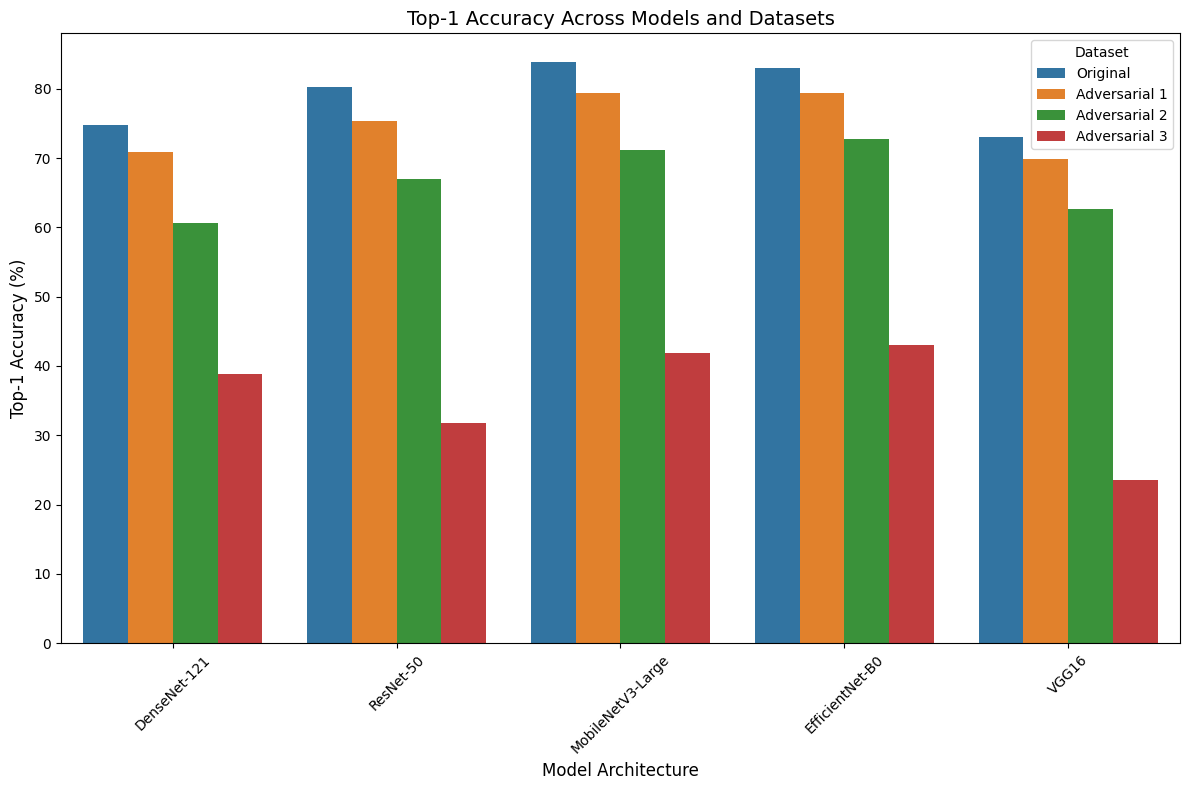

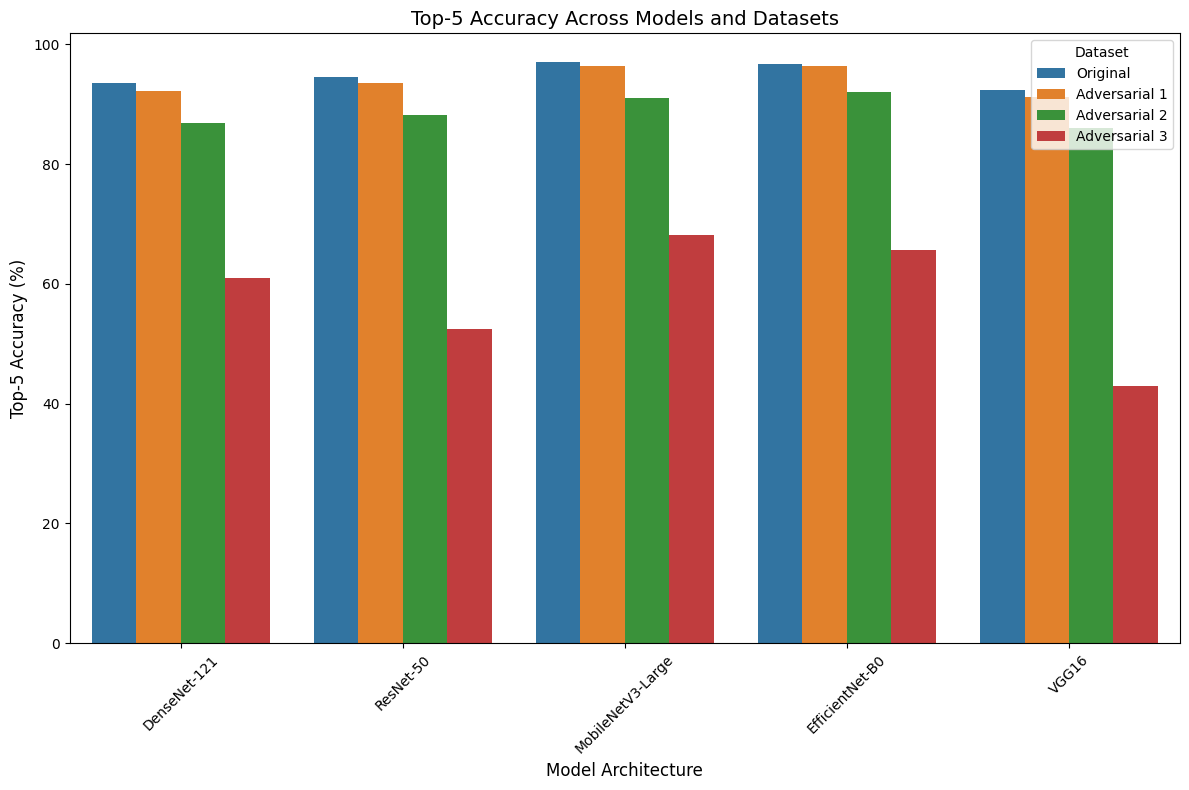

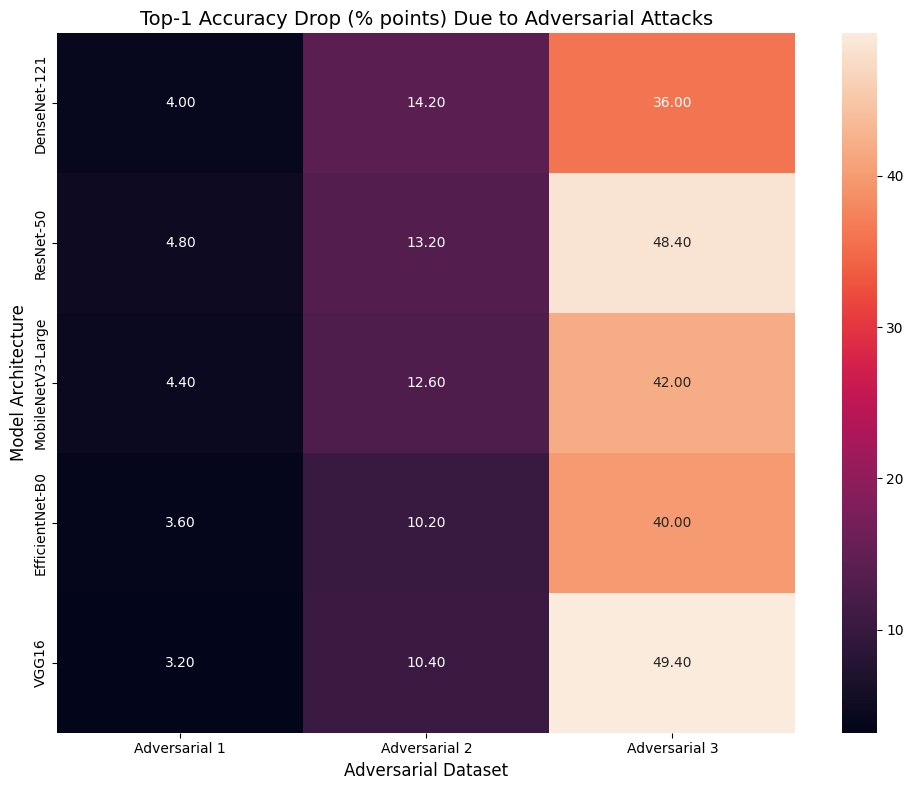


===== TRANSFERABILITY ANALYSIS =====

Transferability Scores (Higher means better transfer):
Adversarial 3  : 43.16% average accuracy drop
Adversarial 2  : 12.12% average accuracy drop
Adversarial 1  : 4.00% average accuracy drop

Model Robustness Against Transferred Attacks (Lower means more robust):
EfficientNet-B0: 17.93% average accuracy drop
DenseNet-121   : 18.07% average accuracy drop
MobileNetV3-Large: 19.67% average accuracy drop
VGG16          : 21.00% average accuracy drop
ResNet-50      : 22.13% average accuracy drop


In [6]:
import os
import json
import urllib.request
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_paths = {
    "Original": "/content/TestDataSet/TestDataSet",
    "Adversarial 1": "/content/AdversarialTestSet1",
    "Adversarial 2": "/content/AdversarialTestSet2",
    "Adversarial 3": "/content/AdversarialTestSet3"
}

for name, path in dataset_paths.copy().items():
    if not os.path.exists(path):
        print(f"Warning: {name} dataset path '{path}' does not exist. Removing from evaluation.")
        dataset_paths.pop(name)

class_index_url = "https://github.com/raghakot/keras-vis/raw/master/resources/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(class_index_url).read().decode("utf-8"))

synset_to_idx = {v[0]: int(k) for k, v in class_index.items()}
idx_to_label = {int(k): v[1] for k, v in class_index.items()}

def load_dataset_with_mapping(path):
    folder_names = sorted([f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))])
    folder_to_idx = {}
    for folder in folder_names:
        if folder in synset_to_idx:
            folder_to_idx[folder] = synset_to_idx[folder]
        else:
            print(f"Warning: Folder {folder} not found in ImageNet synset mapping.")
    dataset = datasets.ImageFolder(root=path, transform=plain_transforms)
    dataset.class_to_idx = folder_to_idx
    dataset.samples = [(path, folder_to_idx[os.path.basename(os.path.dirname(path))]) for (path, _) in dataset.samples]
    return dataset

dataloaders = {}
for name, path in dataset_paths.items():
    if os.path.exists(path):
        try:
            dataset = load_dataset_with_mapping(path)
            dataloaders[name] = DataLoader(dataset, batch_size=32, shuffle=False)
            print(f"Loaded {name} dataset with {len(dataset)} images")
        except Exception as e:
            print(f"Error loading {name} dataset: {e}")

model_dict = {
    "DenseNet-121": torchvision.models.densenet121(weights='IMAGENET1K_V1'),
    "ResNet-50": torchvision.models.resnet50(weights='IMAGENET1K_V1'),
    "MobileNetV3-Large": torchvision.models.mobilenet_v3_large(weights='IMAGENET1K_V1'),
    "EfficientNet-B0": torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1'),
    "VGG16": torchvision.models.vgg16(weights='IMAGENET1K_V1')
}

def evaluate_model(model, dataloader, top_k=(1, 5)):
    model.eval()
    model = model.to(device)
    top_k_correct = {k: 0 for k in top_k}
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, dict) and 'logits' in outputs:
                outputs = outputs['logits']
            _, predictions = outputs.topk(max(top_k), dim=1)
            for k in top_k:
                top_k_preds = predictions[:, :k]
                for i in range(labels.size(0)):
                    if labels[i].item() in top_k_preds[i]:
                        top_k_correct[k] += 1
            total += labels.size(0)

    accuracy = {k: (top_k_correct[k] / total) * 100 for k in top_k}
    return accuracy

results = {}
all_results = []

for model_name, model in model_dict.items():
    print(f"\nEvaluating {model_name}...")
    model_results = {}

    for dataset_name, dataloader in dataloaders.items():
        print(f"  on {dataset_name} dataset...")
        accuracy = evaluate_model(model, dataloader)
        model_results[dataset_name] = accuracy
        all_results.append({
            'Model': model_name,
            'Dataset': dataset_name,
            'Top-1 Accuracy': accuracy[1],
            'Top-5 Accuracy': accuracy[5]
        })

    results[model_name] = model_results

df_results = pd.DataFrame(all_results)

print("\n===== EVALUATION RESULTS =====")
for model_name, model_results in results.items():
    print(f"\n{model_name}:")
    print("-" * (len(model_name) + 1))
    print(f"{'Dataset':<15} {'Top-1 Acc (%)':<15} {'Top-5 Acc (%)':<15}")
    print(f"{'-' * 15:<15} {'-' * 15:<15} {'-' * 15:<15}")
    for dataset_name, accuracy in model_results.items():
        print(f"{dataset_name:<15} {accuracy[1]:<15.2f} {accuracy[5]:<15.2f}")

avg_drop = []
for dataset_name in dataset_paths.keys():
    if dataset_name != "Original":
        top1_drops = []
        top5_drops = []
        for model_name, model_results in results.items():
            if "Original" in model_results and dataset_name in model_results:
                orig_top1 = model_results["Original"][1]
                orig_top5 = model_results["Original"][5]
                adv_top1 = model_results[dataset_name][1]
                adv_top5 = model_results[dataset_name][5]
                top1_drop = orig_top1 - adv_top1
                top5_drop = orig_top5 - adv_top5
                top1_drops.append(top1_drop)
                top5_drops.append(top5_drop)
        if top1_drops and top5_drops:
            avg_drop.append({
                'Dataset': dataset_name,
                'Avg Top-1 Drop': sum(top1_drops) / len(top1_drops),
                'Avg Top-5 Drop': sum(top5_drops) / len(top5_drops)
            })

print("\n===== ATTACK TRANSFERABILITY =====")
print(f"{'Dataset':<15} {'Avg Top-1 Drop':<15} {'Avg Top-5 Drop':<15}")
print(f"{'-' * 15:<15} {'-' * 15:<15} {'-' * 15:<15}")
for drop in avg_drop:
    print(f"{drop['Dataset']:<15} {drop['Avg Top-1 Drop']:<15.2f} {drop['Avg Top-5 Drop']:<15.2f}")

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Top-1 Accuracy', hue='Dataset', data=df_results)
plt.title('Top-1 Accuracy Across Models and Datasets', fontsize=14)
plt.xlabel('Model Architecture', fontsize=12)
plt.ylabel('Top-1 Accuracy (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top1_accuracy_comparison.png')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Top-5 Accuracy', hue='Dataset', data=df_results)
plt.title('Top-5 Accuracy Across Models and Datasets', fontsize=14)
plt.xlabel('Model Architecture', fontsize=12)
plt.ylabel('Top-5 Accuracy (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top5_accuracy_comparison.png')
plt.show()

if len(dataset_paths) > 1:
    drop_matrix = np.zeros((len(model_dict), len(dataset_paths) - 1))
    models_list = list(model_dict.keys())
    datasets_list = [name for name in dataset_paths.keys() if name != "Original"]

    for i, model_name in enumerate(models_list):
        for j, dataset_name in enumerate(datasets_list):
            orig_acc = results[model_name]["Original"][1]
            adv_acc = results[model_name][dataset_name][1]
            drop_matrix[i, j] = orig_acc - adv_acc

    plt.figure(figsize=(10, 8))
    sns.heatmap(drop_matrix, annot=True, fmt=".2f", xticklabels=datasets_list, yticklabels=models_list)
    plt.title('Top-1 Accuracy Drop (% points) Due to Adversarial Attacks', fontsize=14)
    plt.xlabel('Adversarial Dataset', fontsize=12)
    plt.ylabel('Model Architecture', fontsize=12)
    plt.tight_layout()
    plt.savefig('accuracy_drop_heatmap.png')
    plt.show()

def has_original_and_adversarial():
    has_original = "Original" in dataset_paths
    has_adv = any(name != "Original" for name in dataset_paths)
    return has_original and has_adv

if has_original_and_adversarial():
    print("\n===== TRANSFERABILITY ANALYSIS =====")
    transferability_scores = {}

    for dataset_name in dataset_paths:
        if dataset_name != "Original":
            acc_drops = []
            for model_name in model_dict:
                orig_top1 = results[model_name]["Original"][1]
                adv_top1 = results[model_name][dataset_name][1]
                acc_drop = orig_top1 - adv_top1
                acc_drops.append(acc_drop)
            transferability_scores[dataset_name] = sum(acc_drops) / len(acc_drops)

    print("\nTransferability Scores (Higher means better transfer):")
    for dataset, score in sorted(transferability_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{dataset:<15}: {score:.2f}% average accuracy drop")

    robustness_scores = {}
    for model_name in model_dict:
        acc_drops = []
        for dataset_name in dataset_paths:
            if dataset_name != "Original":
                orig_top1 = results[model_name]["Original"][1]
                adv_top1 = results[model_name][dataset_name][1]
                acc_drop = orig_top1 - adv_top1
                acc_drops.append(acc_drop)
        if acc_drops:
            robustness_scores[model_name] = sum(acc_drops) / len(acc_drops)

    print("\nModel Robustness Against Transferred Attacks (Lower means more robust):")
    for model, score in sorted(robustness_scores.items(), key=lambda x: x[1]):
        print(f"{model:<15}: {score:.2f}% average accuracy drop")
